# Tweaking Trajectory Code
- Try to fix large errors on high pt electrons

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
from sys import getsizeof
import math
import numpy as np
import pandas as pd
import pickle as pkl
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode

init_notebook_mode(True)

from mu2e import mu2e_ext_path
#from mu2e.tools.fiteval import get_mag_field_function
from mu2e.tools.modeleval import get_mag_field_function
from mu2e.tools.particletransport import ElectronSwimmer

from hallprobecalib.hpcplots import scatter2d, scatter3d, histo

## First Tests

In [119]:
def get_lin_b(maxfield,minfield=1.):
    def b(x,y,z,cart=True):
        return(0.,0.,(maxfield-minfield)*(z-6000.)/6000. + minfield)
    return b

def get_lin_b2(maxfield,minfield=1.):
    def b(x,y,z,cart=True):
        dbz = (maxfield-minfield)/6000.
        rho = (x**2+y**2)**(1/2)
        brho = -1/2 * rho * dbz
        if (x != 0) and (y != 0):
            phi = np.arctan(y/x)
        else:
            phi = 0
            brho = 0
        return(brho*np.cos(phi),brho*np.sin(phi),dbz*(z-6000.)+ minfield)
    return b

In [218]:
#b_lin = get_lin_b(3.)
b_lin = get_lin_b2(3.) # ~3 and above reflect!
b_const = get_lin_b(1.)

In [140]:
b_lin(100,100,12000)

(-0.04166666666666667, -0.041666666666666664, 6.0)

In [242]:
%timeit b_lin(100,100,12000)

3.92 µs ± 30.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [19]:
b_const(0,0,12000)

(0.0, 0.0, 1.0)

In [258]:
pos = np.array([-29.47, -54.59, -3944.4+10200.])
#pos = np.array([400, 0, -3944.4+10200.]) # reflect!
#pos = np.array([400, 0, -4200.+10200.]) # reflect!
#mom = np.array([55,74,50])
#mom = np.array([70,70,30])
#mom = np.array([0,100,32]) # reflect!
#mom = np.array([89.170445,-54.032551,12.414314])
mom = np.array([0,32,100])
timesteps = np.linspace(0,4e-8,4000)
#timesteps = np.linspace(0,8e-8,8000)

### rtol=1e-3, atol=1e-3

In [34]:
rtol=1e-3
atol=1e-3
swimmer_const = ElectronSwimmer(mom,pos,b_const,timesteps,'Dop853',rtol=rtol,atol=atol)
swimmer_lin = ElectronSwimmer(mom,pos,b_lin,timesteps,'Dop853',rtol=rtol,atol=atol)

In [29]:
x_c,t_c = swimmer_const.solve()
x_c = pd.DataFrame(x_c[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_c['t'] = pd.Series(t_c,name='time')

swimming electron with [55 74 50] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
init energy: 104.88689680306281 MeV
final energy: 104.92470561690062 MeV
energy difference: 0.037808813837813204 MeV (0.03605%)


In [28]:
x_l,t_l = swimmer_lin.solve()
x_l = pd.DataFrame(x_l[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_l['t'] = pd.Series(t_l,name='time')

swimming electron with [55 74 50] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=2.76369e-08
init energy: 104.88689680306281 MeV
final energy: 486.34829920126475 MeV
energy difference: 381.4614023982019 MeV (363.7%)


In [35]:
#df1 = x_c
df1 = x_l
#df2 = x_l
scatter3d(df1.X,df1.Y,df1.Z,scale_list=[df1.t],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)

Figure({
    'data': [{'marker': {'cauto': False,
                         'cmax': 2.760690172543136e-09,
                         'cmin': 0.0,
                         'color': array([0.00000000e+00, 1.00025006e-11, 2.00050013e-11, ..., 2.74068517e-09,
                                         2.75068767e-09, 2.76069017e-09]),
                         'colorbar': {'thickness': 20, 'title': 't (mm)', 'x': -0.1, 'y': 0.5},
                         'colorscale': 'Viridis',
                         'opacity': 0.8,
                         'reversescale': False,
                         'showscale': True,
                         'size': 2},
              'mode': 'markers+lines',
              'name': '<br>x: X (mm)<br>y: Y (mm)<br>z: Z (mm)<br>',
              'type': 'scatter3d',
              'uid': 'fb97447d-5ba4-45ad-9f21-c26ad2889c64',
              'x': array([ -29.47      ,  -14.75309197,   -2.13939094, ..., -584.3952785 ,
                          -605.04720232, -624.89518222]),
  

### rtol=1e-3, atol=1e-4

In [259]:
rtol=1e-5
atol=1e-3
swimmer_const = ElectronSwimmer(mom,pos,b_const,timesteps,'Dop853',rtol=rtol,atol=atol)
#swimmer_const = ElectronSwimmer(mom,pos,b_const,timesteps,'Dopri5',rtol=rtol,atol=atol)
swimmer_lin = ElectronSwimmer(mom,pos,b_lin,timesteps,'Dop853',rtol=rtol,atol=atol)
swimmer_5 = ElectronSwimmer(mom,pos,b_lin,timesteps,'Dopri5',rtol=rtol,atol=atol)

In [271]:
x_c,t_c = swimmer_const.solve()
x_c = pd.DataFrame(x_c[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_c['t'] = pd.Series(t_c,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=2.0125e-08
init energy: 104.99648146930423 MeV
final energy: 104.99648152442444 MeV
energy difference: 5.512021061804262e-08 MeV (5.25e-08%)


In [270]:
# seems reasonable!
#r -3 , a -5
x_l,t_l = swimmer_lin.solve()
#x_l,t_l = swimmer_5.solve()
x_l = pd.DataFrame(x_l[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_l['t'] = pd.Series(t_l,name='time')

swimming electron with [  0  32 100] MeV, starting at [ -29.47  -54.59 6255.6 ] mm, for 4e-08 s
Dop853 terminated at t=1.97449e-08
init energy: 104.99648146930423 MeV
final energy: 104.99650290761889 MeV
energy difference: 2.1438314661281765e-05 MeV (2.042e-05%)


In [234]:
#r -4 , a -4
x_l,t_l = swimmer_lin.solve()
#x_l,t_l = swimmer_5.solve()
x_l = pd.DataFrame(x_l[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_l['t'] = pd.Series(t_l,name='time')

swimming electron with [  0 100  32] MeV, starting at [ 400.    0. 6000.] mm, for 8e-08 s
init energy: 104.99648146930423 MeV
final energy: 144.88918199925558 MeV
energy difference: 39.892700529951355 MeV (37.99%)


In [231]:
#r -5 , a -4
x_l,t_l = swimmer_lin.solve()
#x_l,t_l = swimmer_5.solve()
x_l = pd.DataFrame(x_l[::10],columns=['X','Y','Z','Vx','Vy','Vz'])
x_l['t'] = pd.Series(t_l,name='time')

swimming electron with [  0 100  32] MeV, starting at [ 400.    0. 6000.] mm, for 8e-08 s
init energy: 104.99648146930423 MeV
final energy: 106.03176494367933 MeV
energy difference: 1.035283474375106 MeV (0.986%)


In [272]:
df1 = x_c
#df1 = x_l
#df2 = x_l
scatter3d(df1.X,df1.Y,df1.Z,scale_list=[df1.t],mode_list=['markers+lines'],units_list=[('mm','mm','mm')],inline=True)

Figure({
    'data': [{'marker': {'cauto': False,
                         'cmax': 2.010502625656414e-09,
                         'cmin': 0.0,
                         'color': array([0.00000000e+00, 1.00025006e-11, 2.00050013e-11, ..., 1.99049762e-09,
                                         2.00050013e-09, 2.01050263e-09]),
                         'colorbar': {'thickness': 20, 'title': 't (mm)', 'x': -0.1, 'y': 0.5},
                         'colorscale': 'Viridis',
                         'opacity': 0.8,
                         'reversescale': False,
                         'showscale': True,
                         'size': 2},
              'mode': 'markers+lines',
              'name': '<br>x: X (mm)<br>y: Y (mm)<br>z: Z (mm)<br>',
              'type': 'scatter3d',
              'uid': 'dce9b3c8-6335-4353-bb98-7532cbd8992f',
              'x': array([ -29.47      ,  -29.86100773,  -31.03116626, ..., -161.61835203,
                          -152.65968882, -143.58051174]),
  

In [110]:
x_c.eval('R = (X**2+Y**2)**(1/2)',inplace=True)

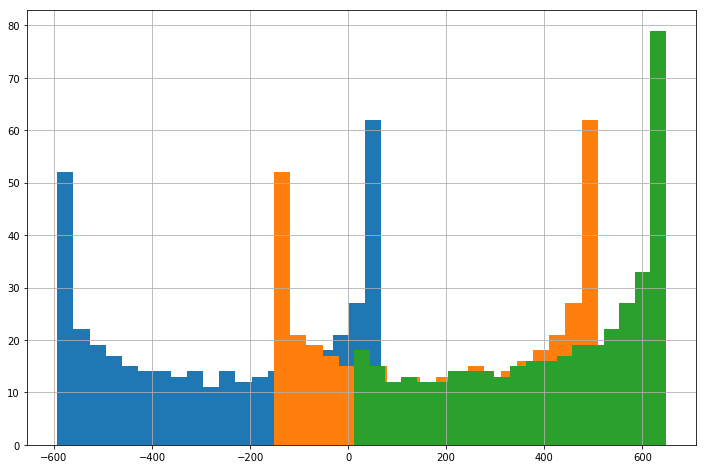

In [112]:
x_c.X.hist(bins=20)
x_c.Y.hist(bins=20)
x_c.R.hist(bins=20)

In [261]:
from mu2e.tools.particletransport import *

In [262]:
gamma(mom)

1.0

In [264]:
init_mom = mom
v = init_mom/(0.511*np.sqrt(1+np.dot(init_mom,init_mom)/0.511**2))*c

In [267]:
np.sqrt(np.dot(v,v)) / 1e11

2.997889075321219

In [268]:
gamma(v)

205.47256647613352

In [274]:
t = 2.0125e-8

In [281]:
vz_real = (12000 - pos[2]) / t
vz_real

285436024844.72046

In [278]:
v[2]

285526194596.09827

In [282]:
(vz_real-v[2])/v[2]

-0.00031580202827050807

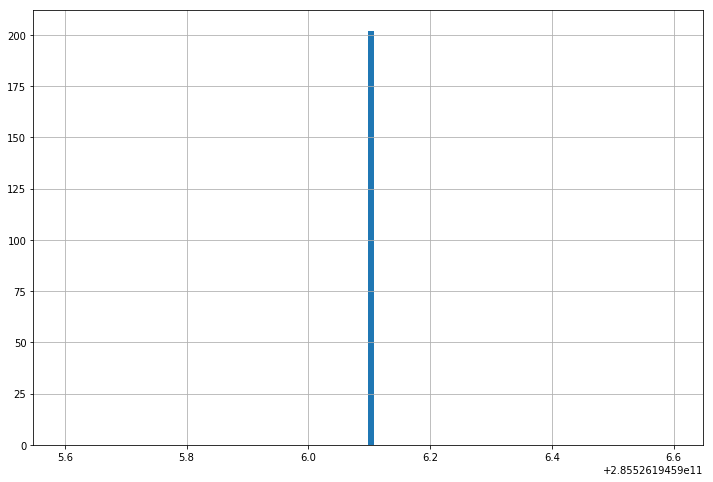

In [285]:
x_c.Vz.hist(bins=100)

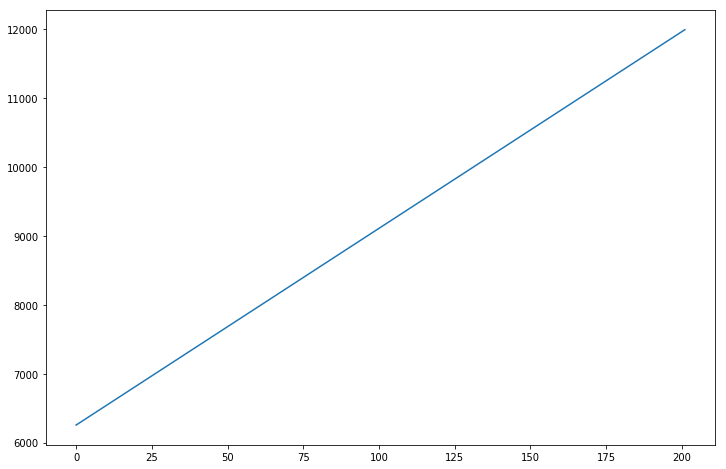

In [286]:
x_c.Z.plot()